In [18]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

import perturbseq as perturb

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [19]:
PROTEIN='KRAS'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
SUBSAMPLED=DATA+'/'+PROTEIN+'/subsampled/A549.'+PROTEIN

counts=20000

FIGS=DATA+'/2020-09-15_Figures/'
os.system('mkdir -p '+FIGS)
print(FIGS)

sc.settings.figdir=FIGS

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/2020-09-15_Figures/


In [20]:
adata=sc.read(SUBSAMPLED+'.channel_1to32.counts_per_cell'+str(counts)+'.regress_out_vbc.analysis.1000cells.new_format.h5ad',cache=False)
adata

Only considering the two last: ['.new_format', '.h5ad'].
Only considering the two last: ['.new_format', '.h5ad'].


AnnData object with n_obs × n_vars = 90262 × 1145 
    obs: 'batch', 'known', 'n_counts', 'n_genes', 'percent_mito', 'n_counts_downsampled', 'n_counts_original', 'vbc.counts', 'batch_num4', 'batch_num7', 'batch_num11', 'batch_num8', 'batch_num13', 'batch_num23', 'batch_num9', 'batch_num2', 'batch_num24', 'batch_num10', 'batch_num12', 'batch_num16', 'batch_num20', 'batch_num18', 'batch_num25', 'batch_num31', 'batch_num28', 'batch_num5', 'batch_num14', 'batch_num15', 'batch_num29', 'batch_num3', 'batch_num6', 'batch_num22', 'batch_num26', 'batch_num17', 'batch_num27', 'batch_num1', 'batch_num19', 'batch_num21', 'batch_num0', 'batch_num30', 'louvain', 'G1.S', 'G2.M', 'M', 'M.G1', 'S', 'phase.multi', 'guide', 'guide.compact', 'A146P', 'K117R', 'Y166H', 'K169K', 'K178K', 'T50P', 'A146V', 'L52F', 'K176Q', 'A155G', 'G60D', 'T158T', 'K88K', 'D119G', 'L159S', 'G13V', 'Q61P', 'D33E', 'S136N', 'K179R', 'T74T', 'G60S', 'Q99E', 'G13R', 'G12D', 'R164Q', 'I36M', 'C185Y', 'I163S', 'P34R', 'G60V', 'G12

In [21]:
ref='K169K'
methods=['bulk.L1','HotellingT2','bulk.spearman','bulk.pearson']

#collect the variants into a list
variants=perturb.util.get_perturbations(adata,compact=True)
variants.append('unassigned')
print(variants)
print(len(variants))

['A130V', 'A146P', 'A146T', 'A146V', 'A155G', 'A59E', 'A59G', 'A59T', 'A66A', 'AG11TD', 'AG59GV', 'C118S', 'C185Y', 'D119G', 'D173D', 'D30D', 'D33E', 'D57N', 'E31K', 'E63K', 'F141L', 'G12A', 'G12C', 'G12D', 'G12F', 'G12I', 'G12R', 'G12S', 'G12V', 'G12Y', 'G13C', 'G13E', 'G13R', 'G13V', 'G60D', 'G60S', 'G60V', 'G75A', 'G77A', 'I163S', 'I36M', 'K117N', 'K117R', 'K147N', 'K147T', 'K169K', 'K176Q', 'K178K', 'K179R', 'K5E', 'K88K', 'L159S', 'L19F', 'L52F', 'L79I', 'M111L', 'M170L', 'N26Y', 'P110S', 'P34L', 'P34R', 'Q22H', 'Q22K', 'Q25H', 'Q61A', 'Q61H', 'Q61K', 'Q61L', 'Q61P', 'Q61R', 'Q99E', 'R135T', 'R149K', 'R164Q', 'R41K', 'R68S', 'S136N', 'S17S', 'T127T', 'T144P', 'T144T', 'T158A', 'T158T', 'T20M', 'T20R', 'T20T', 'T50I', 'T50P', 'T50T', 'T58I', 'T74A', 'T74T', 'V112I', 'V14I', 'V14L', 'V8V', 'WT', 'Y166H', 'unassigned']
99


In [22]:
#============ COMPARING PERTURBATIONS
def compare_2_groups_df(adata_df,
                     group1_cells,group2_cells,
                     method,
                     ps=1e-300):
    
    v1_data=adata_df.loc[group1_cells,:]
    v2_data=adata_df.loc[group2_cells,:]

    #T2 Hotelling
    #============
    if method=='HotellingT2':
        import spm1d
        
        T2=spm1d.stats.hotellings2(v1_data,v2_data)
        ##T2i=T2.inference(0.0005)
        ##pval=T2i.p+ps #p-value
        value=T2.z #the T2 statistic

    #bulk analysis
    #==============
    if 'bulk' in method:
        #get the bulkified data
        v1_bulk=np.mean(np.array(v1_data),axis=0)
        v2_bulk=np.mean(np.array(v2_data),axis=0)

    if method=='bulk.pearson':
        from scipy.stats import pearsonr
        value=1-pearsonr(v1_bulk,v2_bulk)[0]

    if method=='bulk.spearman':
        from scipy.stats import spearmanr
        value=1-spearmanr(v1_bulk,v2_bulk)[0]
        
    if method=='bulk.L1':
        value=np.sum(np.abs(v1_bulk-v2_bulk))*1.0/v1_data.shape[1]

    return(value)

def compare_two_groups(adata_here,
                       v1,v2,
                       methods=['HotellingT2','bulk.pearson','bulk.spearman','bulk.L1'],
                       num_pcs_hotelling=20):
    #convert the adata to a data frame here
    data_here=pd.DataFrame(adata_here.X,
                          columns=adata_here.var_names,
                         index=adata_here.obs_names)
    if 'HotellingT2' in methods:
        data_here_pca=pd.DataFrame(adata_here.obsm['X_pca'][:,:num_pcs_hotelling],
                             index=adata_here.obs_names)
    
    v1_cells=adata_here.obs_names[adata_here.obs[v1]>0]
    v2_cells=adata_here.obs_names[adata_here.obs[v2]>0]
    
    comparison_name=v1+'.VS.'+v2
    cols=['group1','group2']
    for m in methods:
        cols.append(m)
    df_comparison=pd.DataFrame(0,columns=cols,index=[comparison_name])
    
    for method in methods:
        if method=='HotellingT2':
            v=compare_2_groups_df(data_here_pca,v1_cells,v2_cells,method)
        else:
            v=compare_2_groups_df(data_here,v1_cells,v2_cells,method)
        df_comparison.loc[comparison_name,method]=v
        df_comparison.loc[comparison_name,'group1']=v1
        df_comparison.loc[comparison_name,'group2']=v2
    df_comparison=df_comparison.reset_index(drop=True)
        
    return(df_comparison)



def compare_groups_with_reference(adata_here,
                                 groups,
                                 reference,
                                 methods=['HotellingT2','bulk.pearson','bulk.spearman','bulk.L1'],
                                 num_pcs_hotelling=20,
                                 permuted=False):
    
    if permuted:
        permuted_df=adata_here.uns['permuted']
        for label in permuted_df.columns:
            adata_here.obs['permuted.'+label]=list(permuted_df[label])
    
    results_col=['group1','group2']
    for c in methods:
        results_col.append(c)
    results=pd.DataFrame(columns=results_col)
    
    for group in groups:
        group_final=group
        ref_final=reference
        if permuted:
            group_final='permuted.'+group
            ref_final='permuted.'+reference
        x=compare_two_groups(adata_here,
                     ref_final,group_final,
                    methods,
                    num_pcs_hotelling)
        results=pd.concat([results,x],axis=0)
        
    if permuted:
        permuted_df=adata_here.uns['permuted']
        for label in permuted_df.columns:
            del adata_here.obs['permuted.'+label]
            
    return(results)

def permute_labels(adata_here,
                  groups,
                  copy_adata=False,
                  seedname=0):
    import copy
    
    if copy_adata:
        adata_here=copy.deepcopy(adata_here)
    
    df_here=adata_here.obs.loc[:,groups]
    
    #permute the order of the rows
    permuted_order=df_here.sample(frac=1,random_state=seedname).reset_index(drop=True)
    
    adata_here.uns['permuted']=permuted_order
    
    if copy_adata:
        return(adata_here)
    
#run for permuted data. need to do this in a way that can be automated for the user
def get_permuted_scores(adata_here,
                        variants,
                        reference,
                       num_perm=10,
                        methods=['HotellingT2','bulk.pearson','bulk.spearman','bulk.L1'],
                        num_pcs_hotelling=20):
    
    started=False
    for perm in range(num_perm):
        print('permutation',perm)
        permute_labels(adata_here,variants,seedname=perm)
        res_perm=compare_groups_with_reference(adata_here,
                                 variants,
                                 reference,
                                 permuted=True,
                                methods=methods,
                                num_pcs_hotelling=num_pcs_hotelling)
        if not started:
            perm_scores=res_perm
            started=True
        else:
            perm_scores=pd.concat([perm_scores,res_perm],axis=0)
    del adata_here.uns['permuted']
            
    return(perm_scores)

def get_threshold_at_FDR(fdr_data,method,FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data['FDR.'+method]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)

def compute_FDR(res_true,res_perm,methods,plot=False,FDR=0.01):
    
    res_true['dataset']='true data'
    res_perm['dataset']='permuted data'
    res_combo=pd.concat([res_true,res_perm],axis=0)
    min_fdr=1.0/res_combo.shape[0]
    for method in methods:
        res_combo=res_combo.sort_values(by=method,ascending=False)
        res_combo['FDR.'+method]=1
        res_combo=res_combo.reset_index(drop=True)
        for i in range(res_combo.shape[0]):
            value_here=float(list(res_combo[method])[i])
            idx=list(res_combo.index)[i]
            passed=res_combo.loc[res_combo[method]>=value_here,:]
            true_pass=np.sum(passed['dataset']=='true data')
            perm_pass=np.sum(passed['dataset']=='permuted data')
            
            true_fraction=1.0*true_pass/res_true.shape[0]
            perm_fraction=1.0*perm_pass/res_perm.shape[0]
            
            fdr_here=max(float(1.0*perm_fraction/(perm_fraction+true_fraction)),
                            float(min_fdr))       
            res_combo.loc[idx,'FDR.'+method]=float(fdr_here)
            
        if plot:
            #get even bins
            NUM_BINS=20
            max_val=np.max(res_combo[method])
            mybins=[x*max_val/NUM_BINS for x in range(NUM_BINS)]
            scores_true=res_combo.loc[res_combo['dataset']=='true data',method]
            scores_perm=res_combo.loc[res_combo['dataset']=='permuted data',method]
            plt.hist(scores_true,color='red',bins=mybins,label='Real data')
            plt.hist(scores_perm,color='black',alpha=0.5,bins=mybins,
                     weights=[len(scores_true)/len(scores_perm)]*len(scores_perm),
                    label='Permuted data')
            plt.grid(False)
            plt.xlabel(method)
            plt.ylabel('Frequency')
            #thresh_data=res_combo.loc[res_combo['FDR.'+method]<=0.01,:]
            #thresh_data=thresh_data.sort_values(by=method,ascending=True)
            #thresh=list(thresh_data[method])[0]
            thresh=get_threshold_at_FDR(res_combo.loc[res_combo['dataset']=='true data',:],method,FDR)
            thresh=int(1000*thresh)/1000
            plt.axvline(x=thresh,color='black',linestyle='dotted')
            plt.title('FDR '+str(FDR)+' threshold: '+str(thresh))
            plt.legend()
            plt.show()

    to_return=res_combo.loc[res_combo['dataset']=='true data',:]
    to_return=to_return.drop(columns=['dataset'])
    return(to_return)
    


In [23]:
#compute scores
scores_real=compare_groups_with_reference(adata,
                                         variants,
                                         ref,
                                         methods=methods)

permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9


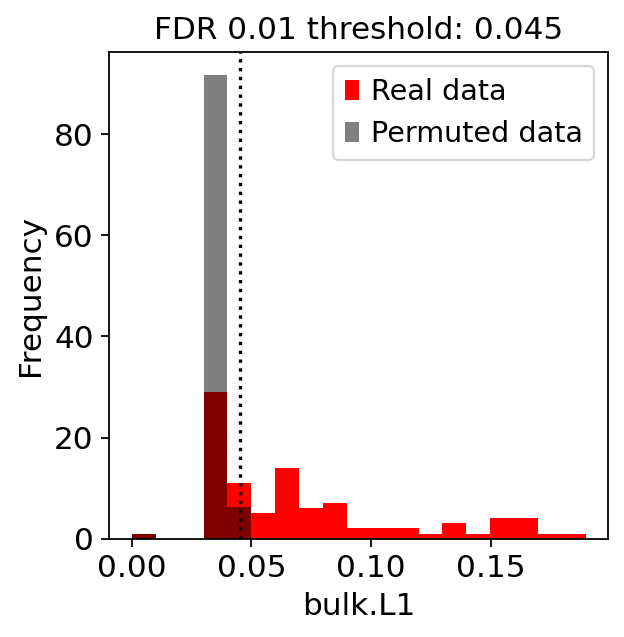

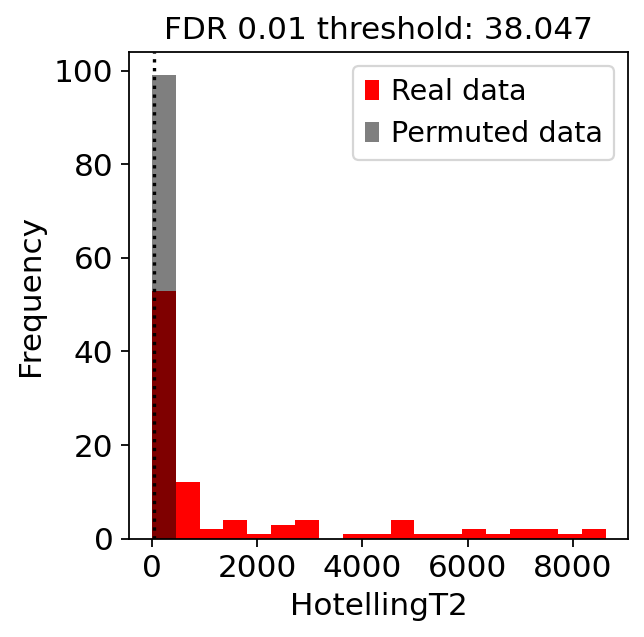

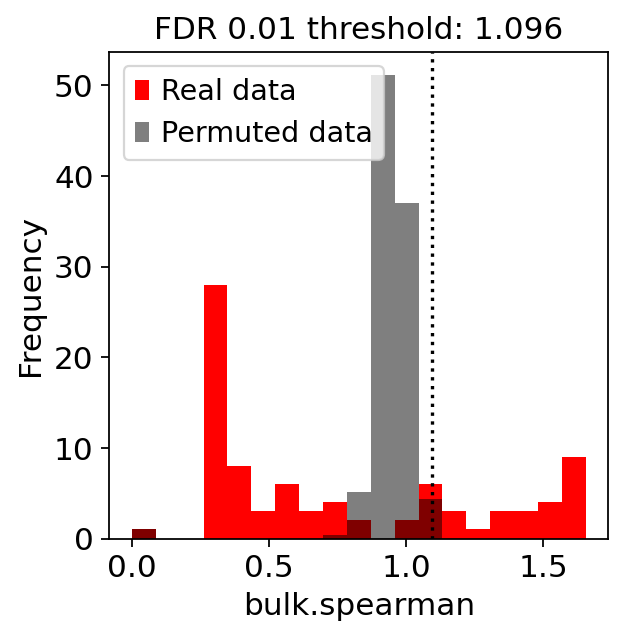

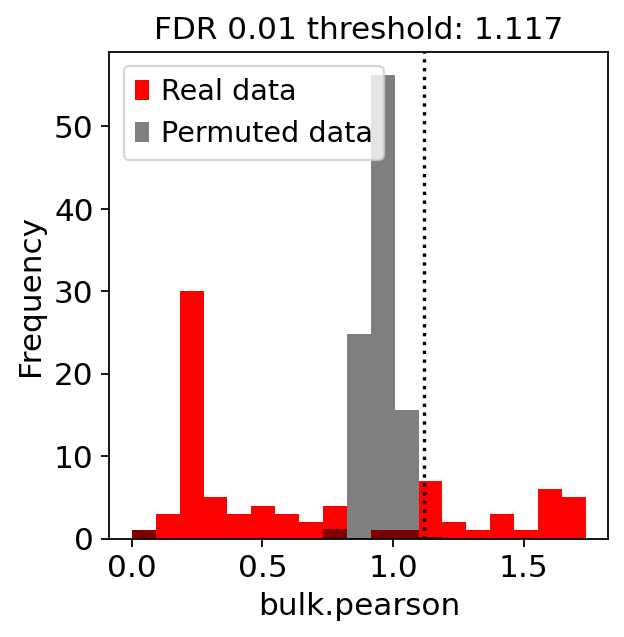

In [24]:
#get empirical distribution of scores on permuted data
scores_perm=get_permuted_scores(adata,
                                variants,
                                ref,
                                num_perm=10,
                                methods=methods)


#assign FDR based on permuted data
fdr_data=compute_FDR(scores_real,
                     scores_perm,
                     methods=methods,
                     plot=True)

In [25]:
score_thresh_value=get_threshold_at_FDR(fdr_data,method='HotellingT2',FDR=0.01)

In [26]:
#read in the annotation file to add the clusters to it
FDR=0.01
#original anno
ANNO=DATA+'/'+PROTEIN+'/anno'
anno=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.complete2.csv',sep='\t')
anno.index=anno['Variant']

anno['Position']=anno['Position'].astype('Int32')
anno['Count_pancan']=anno['Count_pancan'].astype('Int32')
anno['Count_ExAC']=anno['Count_ExAC'].astype('Int32')

syn=list(set(anno.loc[anno['control_status']=='synonymous','Variant']).intersection(set(variants)))
print(syn)
anno.head()

['T50T', 'K88K', 'K178K', 'S17S', 'T74T', 'T127T', 'T20T', 'D30D', 'WT', 'A66A', 'D173D', 'T158T', 'K169K', 'T144T', 'V8V']


,Variant,Variant.1,Position,From,To,mutation_type,Count_pancan,Count_ExAC,control_status,control_color,Library_synthesis,long_name,control_status2
Variant,,,,,,,,,,,,,
G12D,G12D,G12D,12,C,T,Single,1782,NaN,unknown,white,in,KRAS_G12D,hotspot
G12V,G12V,G12V,12,C,A,Single,1539,NaN,unknown,white,in,KRAS_G12V,hotspot
G12C,G12C,G12C,12,C,A,Single,1110,NaN,unknown,white,in,KRAS_G12C,hotspot
G13D,G13D,G13D,13,C,T,Single,582,NaN,unknown,white,not in library,NaN,hotspot
G12A,G12A,G12A,12,C,G,Single,353,NaN,unknown,white,in,KRAS_G12A,hotspot


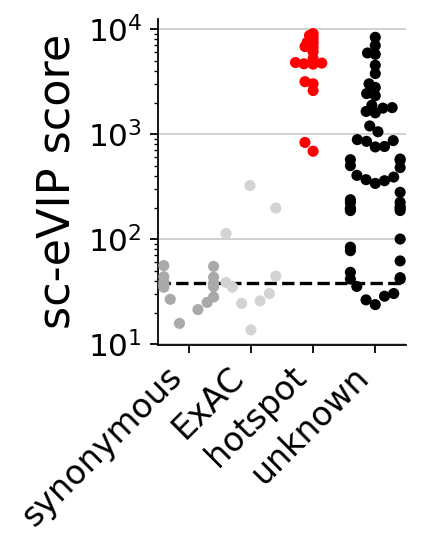

In [27]:
score='HotellingT2'
fdr_data['control_status2']=list(anno.loc[fdr_data['group2'],'control_status2']) 

mypal={'synonymous':'darkgray',
      'ExAC':'lightgray','hotspot':'red','unknown':'black'}
g =sns.catplot(x="control_status2", y=score, 
              order=['synonymous','ExAC','hotspot','unknown'],
              height=3, 
                aspect=1,legend=False,kind='swarm',data=fdr_data,
              hue='control_status2',palette=mypal)

ax1 = g.axes[0,0]
ax1.axhline(y=score_thresh_value,color='black',linestyle='--')
ax1.set_xlabel('',fontsize=20)
ax1.set_ylabel('sc-eVIP score',fontsize=20)
ax1.set_xticklabels(['synonymous','ExAC','hotspot','unknown'],rotation=45,fontsize=15,
                   ha='right')
ax1.set_yscale('log')

plt.savefig(FIGS+'/'+PROTEIN+'.sceVIPscore_swarm.normal_perm.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/'+PROTEIN+'.sceVIPscore_swarm.normal_perm.png',bbox_inches = "tight")

In [28]:
def permute_labels_custom(adata_here,
                  groups,
                  reference,
                  copy_adata=False,
                  seedname=0):
    import copy
    
    if copy_adata:
        adata_here=copy.deepcopy(adata_here)
    
    df_here=adata_here.obs.loc[:,groups]
    
    #permute the columns
    permuted_order=df_here.T.sample(frac=1,random_state=seedname).T
    permuted_order.columns=groups
    
    #make sure the reference has as many cells as it had originally
    num_cells_reference=int(df_here.sum(axis=0)[reference])
    new_reference_cells=adata_here.obs_names[permuted_order[reference]>0]
    permuted_order.index=adata_here.obs_names
    
    if len(new_reference_cells)>num_cells_reference:
        permuted_order[reference]=0
        permuted_order.loc[new_reference_cells[:num_cells_reference],reference]=1
    
    adata_here.uns['permuted']=permuted_order
    
    if copy_adata:
        return(adata_here)

def get_permuted_scores_custom(adata_here,
                        groups,
                        reference,
                       num_perm=10,
                        methods=['HotellingT2','bulk.pearson','bulk.spearman','bulk.L1'],
                        num_pcs_hotelling=20):
    
    started=False
    for perm in range(num_perm):
        print('permutation',perm)
        permute_labels_custom(adata_here,
                  groups,reference,
                  copy_adata=False,
                    seedname=perm)
        res_perm=compare_groups_with_reference(adata_here,
                                 groups,
                                 reference,
                                 permuted=True,
                                methods=methods,
                                num_pcs_hotelling=num_pcs_hotelling)
        if not started:
            perm_scores=res_perm
            started=True
        else:
            perm_scores=pd.concat([perm_scores,res_perm],axis=0)
            
    return(perm_scores)

permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:170: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



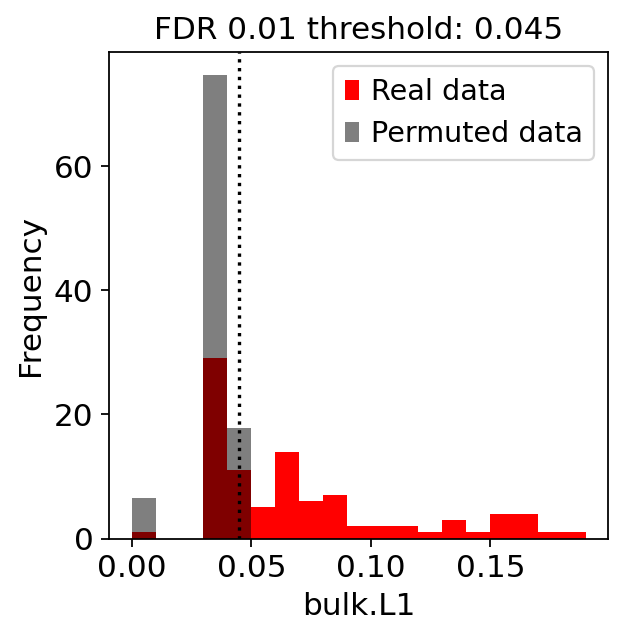

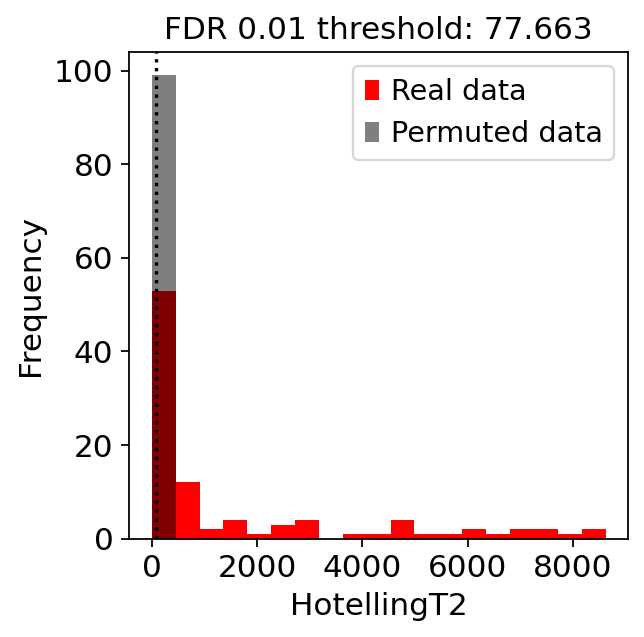

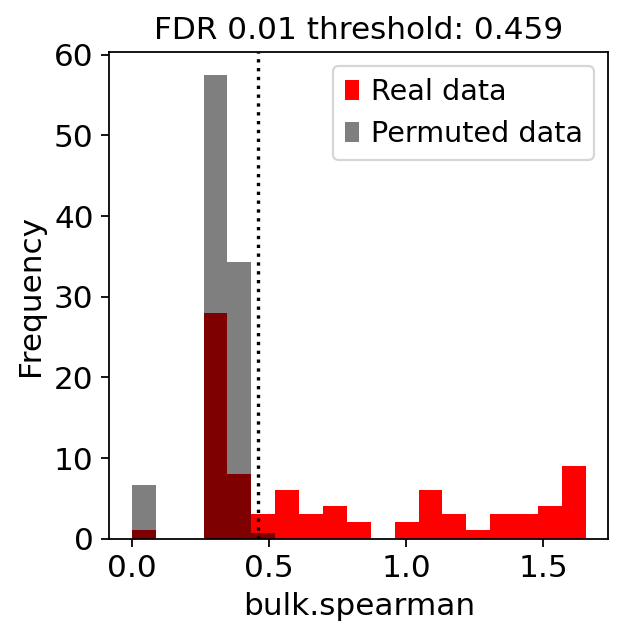

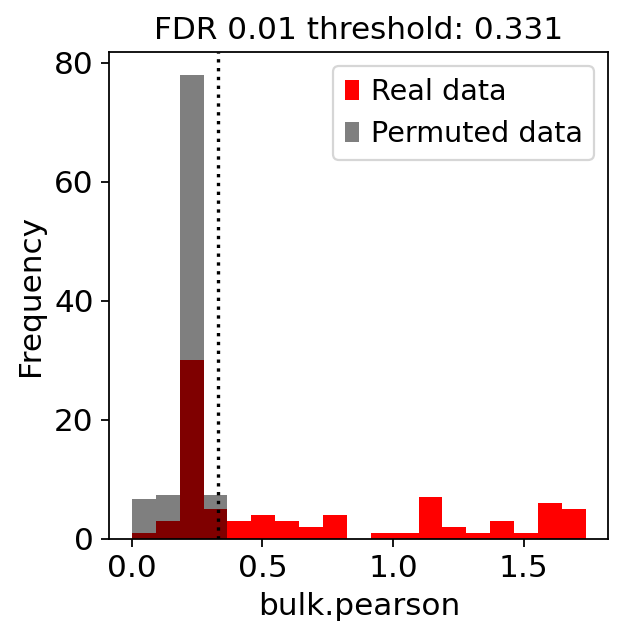

In [29]:
scores_perm_custom=get_permuted_scores_custom(adata,
                                                         syn,
                                                         ref,
                                                         num_perm=10)

#assign FDR based on permuted data
fdr_data=compute_FDR(scores_real,
                                scores_perm_custom,
                                 methods=methods,
                                 plot=True)

In [30]:
score_thresh_value=get_threshold_at_FDR(fdr_data,method='HotellingT2',FDR=0.01)

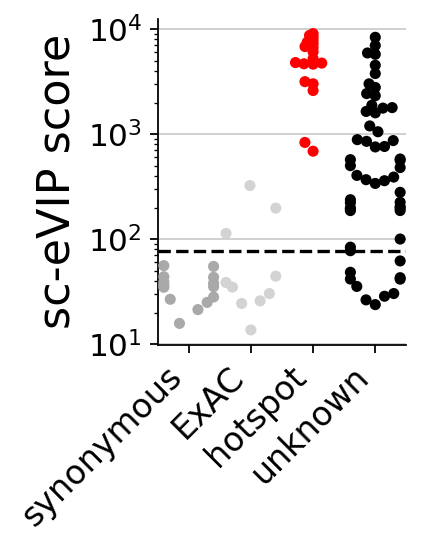

In [31]:
score='HotellingT2'
fdr_data['control_status2']=list(anno.loc[fdr_data['group2'],'control_status2']) 

mypal={'synonymous':'darkgray',
      'ExAC':'lightgray','hotspot':'red','unknown':'black'}
g =sns.catplot(x="control_status2", y=score, 
              order=['synonymous','ExAC','hotspot','unknown'],
              height=3, 
                aspect=1,legend=False,kind='swarm',data=fdr_data,
              hue='control_status2',palette=mypal)

ax1 = g.axes[0,0]
ax1.axhline(y=score_thresh_value,color='black',linestyle='--')
ax1.set_xlabel('',fontsize=20)
ax1.set_ylabel('sc-eVIP score',fontsize=20)
ax1.set_xticklabels(['synonymous','ExAC','hotspot','unknown'],rotation=45,fontsize=15,
                   ha='right')
ax1.set_yscale('log')

plt.savefig(FIGS+'/'+PROTEIN+'.sceVIPscore_swarm.custom_perm.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/'+PROTEIN+'.sceVIPscore_swarm.custom_perm.png',bbox_inches = "tight")

In [32]:
#save scores
fdr_data.to_csv(DATA+'/'+PROTEIN+'/scoring/'+PROTEIN+'.scores_vs_'+ref+'.csv')

In [34]:
#mega subsampling
SUBSAMPLING_LIST=[1000,900,800,700,600,500,400,300,200] #then every 10
#SUBSAMPLING_LIST=[200,190,180,170,160,150,140,130,120,110,100,90,80,70,60,50,40,30,20,10]
ITERATIONS=range(10)
ref='K169K'
methods=['HotellingT2']
#synonymous
OUT_PREF=DATA+'/'+PROTEIN+'/scoring/'+PROTEIN
os.system('mkdir -p '+os.path.dirname(OUT_PREF))
import random
random.seed(100)

for subs_idx,subs in enumerate(SUBSAMPLING_LIST):
    for iter_idx,iter_name in enumerate(ITERATIONS):
        out_here=OUT_PREF+'.cellsPerVar'+str(subs)+'.iter'+str(iter_name)+'.scores.gz'
        print('subsampling:',subs,'iteration:',iter_name)
        print(out_here)
        
        #subsample an adata - should add a random seed here too #======
        adata_subsampled=perturb.pp.subsample_cells(adata,subs,'guide.compact')
        
        #compute scores
        scores_real=compare_groups_with_reference(adata_subsampled,
                                                             variants,
                                                             ref,
                                                             methods=methods)
        
        scores_perm_custom=get_permuted_scores_custom(adata_subsampled,
                                                                 syn,
                                                                 ref,
                                                                 num_perm=10,
                                                                methods=methods)

        #assign FDR based on permuted data
        fdr_data=compute_FDR(scores_real,
                                        scores_perm_custom,
                                        methods=methods,
                                        plot=False)
        
        fdr_data.to_csv(out_here,sep='\t',compression='gzip',index=False)

subsampling: 1000 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar1000.iter0.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 1000 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar1000.iter1.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 1000 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar1000.iter2.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 1000 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar1000.iter3.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 1000 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar1000.iter4.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 1000 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar1000.iter5.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 1000 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar1000.iter6.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 1000 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar1000.iter7.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 1000 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar1000.iter8.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 1000 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar1000.iter9.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 900 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar900.iter0.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 900 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar900.iter1.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 900 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar900.iter2.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 900 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar900.iter3.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 900 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar900.iter4.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 900 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar900.iter5.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 900 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar900.iter6.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 900 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar900.iter7.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 900 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar900.iter8.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 900 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar900.iter9.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 800 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar800.iter0.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 800 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar800.iter1.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 800 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar800.iter2.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 800 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar800.iter3.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 800 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar800.iter4.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 800 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar800.iter5.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 800 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar800.iter6.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 800 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar800.iter7.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 800 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar800.iter8.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 800 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar800.iter9.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 700 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar700.iter0.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 700 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar700.iter1.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 700 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar700.iter2.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 700 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar700.iter3.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 700 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar700.iter4.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 700 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar700.iter5.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 700 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar700.iter6.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 700 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar700.iter7.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 700 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar700.iter8.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 700 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar700.iter9.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 600 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar600.iter0.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 600 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar600.iter1.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 600 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar600.iter2.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 600 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar600.iter3.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 600 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar600.iter4.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 600 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar600.iter5.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 600 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar600.iter6.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 600 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar600.iter7.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 600 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar600.iter8.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 600 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar600.iter9.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 500 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar500.iter0.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 500 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar500.iter1.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 500 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar500.iter2.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 500 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar500.iter3.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 500 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar500.iter4.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 500 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar500.iter5.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 500 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar500.iter6.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 500 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar500.iter7.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 500 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar500.iter8.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 500 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar500.iter9.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 400 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar400.iter0.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 400 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar400.iter1.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 400 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar400.iter2.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 400 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar400.iter3.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 400 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar400.iter4.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 400 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar400.iter5.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 400 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar400.iter6.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 400 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar400.iter7.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 400 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar400.iter8.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 400 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar400.iter9.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 300 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar300.iter0.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 300 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar300.iter1.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 300 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar300.iter2.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 300 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar300.iter3.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 300 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar300.iter4.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 300 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar300.iter5.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 300 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar300.iter6.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 300 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar300.iter7.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 300 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar300.iter8.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 300 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar300.iter9.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 200 iteration: 0
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar200.iter0.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 200 iteration: 1
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar200.iter1.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 200 iteration: 2
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar200.iter2.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 200 iteration: 3
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar200.iter3.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 200 iteration: 4
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar200.iter4.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 200 iteration: 5
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar200.iter5.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 200 iteration: 6
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar200.iter6.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 200 iteration: 7
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar200.iter7.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 200 iteration: 8
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar200.iter8.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
subsampling: 200 iteration: 9
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/KRAS/scoring/KRAS.cellsPerVar200.iter9.scores.gz


Trying to set attribute `.uns` of view, copying.


permutation 0
permutation 1
permutation 2
permutation 3
permutation 4
permutation 5
permutation 6
permutation 7
permutation 8
permutation 9
